## Model Fitting Part 2: Correlation-based Face Detection

In the previous example, the elixir icons that appear in the different locations of image are exact copies of the template. So, comparing them to the template using normalized cross-correlation will give us a result very close to 1.0 in all cases. Now, what if we want to use template matching to detect faces in an image? For simplicity we will only assume frontal views of faces. Different faces have more or less the same shape, but they also have differences, e.g. some people wear glasses, some people wear a hat, some people have a beard, etc. Using the face of a particular person as a template would probably work well for some people, but not for others. To create a template that is more likely to match most people, we can create an "average face" by taking the average multiple faces from a large dataset.

Let's load a few faces from our face dataset.

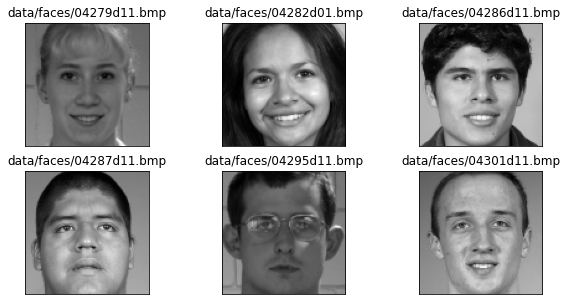

In [1]:
# Necessary imports
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt


# Load faces dataset
filenames = [
    'data/faces/04279d11.bmp', 
    'data/faces/04282d01.bmp',
    'data/faces/04286d11.bmp',
    'data/faces/04287d11.bmp',
    'data/faces/04295d11.bmp',
    'data/faces/04301d11.bmp'
    ]

# Load images
images = [cv.imread(filename,cv.IMREAD_GRAYSCALE) for filename in filenames]

# Display the images
plt.figure(figsize = (10,5))
for i in range(len(images)):
    plt.subplot(2,3,i+1), plt.imshow(images[i], cmap='gray')
    plt.title(filenames[i]), plt.xticks([]), plt.yticks([])
plt.show()

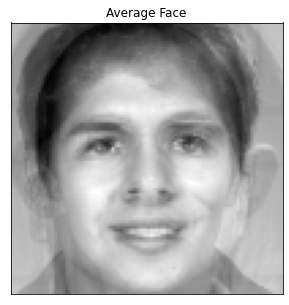

In [2]:
# Computer average face
average_face = np.zeros((images[0].shape[0], images[0].shape[1]))
for image in images:
    average_face += image
average_face /= len(images)

# Display the average face
plt.figure(figsize = (5,5))
plt.imshow(average_face, cmap='gray')
plt.title('Average Face'), plt.xticks([]), plt.yticks([])
plt.show()


The image above is the average of six faces from our dataset. Now let's compute the average face from all 337 faces in the dataset.

Number of images: 337


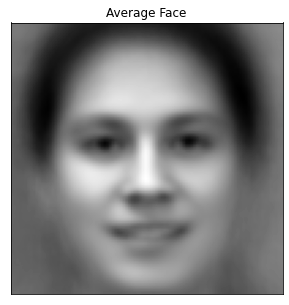

In [3]:
# Load all images in the folder data/faces
import os
filenames = [ 'data/faces/' + filename for filename in os.listdir('data/faces') ]
images = [cv.imread(filename,cv.IMREAD_GRAYSCALE) for filename in filenames]

print('Number of images:', len(images))

# Computer average face
average_face = np.zeros((images[0].shape[0], images[0].shape[1]))
for image in images:
    average_face += image
average_face /= len(images)

# Display the average face
plt.figure(figsize = (5,5))
plt.imshow(average_face, cmap='gray')
plt.title('Average Face'), plt.xticks([]), plt.yticks([])
plt.show()


The original size of the face images is 100x100 pixels. To increase the likelihood of a match, we will further crop the template and keep the parts of the average face that are most likely to be present in all faces:
- Exclude background.
- Exclude forehead (highly variable appearance, due to hair).
- Exclude lower chin.

(60, 50)


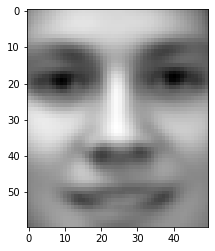

In [4]:
# Crop the average face to a square of size 60x50
average_face = average_face[25:85, 25:75]
print(average_face.shape)

plt.imshow(average_face, cmap='gray')    

We can now use the average face template to detect faces in the image. Before we do so, we need to solve one more problem. Our template is of shape (61, 50) pixels. Therefore it can only work well for faces that are of the same size. It could also be that the faces are not in exactly the upright position. To solve this problem, we need to resize the template to different scales and will also rotate it to different orientations.

In [48]:
# Auxiliary function to rotate an image
def rotate(image, angle, center = None):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv.getRotationMatrix2D(center, angle, scale = 1.0)
    rotated = cv.warpAffine(image, M, (w, h), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)

    return rotated

In [49]:
# To better understand how correlation-based template matching works, we create our own custom function to 
# calculate the normalized cross correlation coefficient between an image and a template.
# This function is similar to the cv.matchTemplate(image, template, cv.TM_CCOEFF_NORMED) that we used before,
# but it is not optimized for speed and it is easier to understand.
def normalized_cross_correlation(image, template):
    image = image.astype(float)
    template = template.astype(float)

    h, w = template.shape
    result = np.zeros_like(image)

    template_mean = np.mean(template)
    template_std = np.std(template)
    template_norm = (template - template_mean) / template_std

    for y in range(image.shape[0] - h + 1):
        for x in range(image.shape[1] - w + 1):
            window = image[y:y + h, x:x + w]
            window_mean = np.mean(window)
            window_std = np.std(window)
            window_norm = (window - window_mean) / (window_std + 1e-8)

            # Calculate the correlation coefficient
            result[y, x] = np.sum(window_norm * template_norm) / (w * h)

    return result

Implementation of a multi-scale, multi-orientation template matching algorithm.

Detected face at scale 0.5 and angle -15 with confidence 0.5651842
Detected face at scale 0.5 and angle -10 with confidence 0.57628125
Detected face at scale 0.5 and angle -5 with confidence 0.55416197
Detected face at scale 0.5 and angle -5 with confidence 0.5751682
Detected face at scale 0.5 and angle -5 with confidence 0.5523998
Detected face at scale 0.5 and angle 0 with confidence 0.5540106


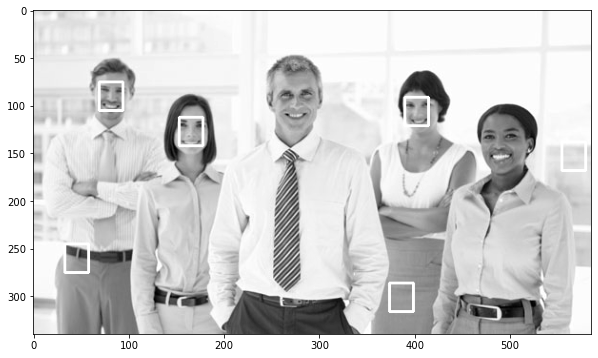

In [53]:


img = cv.imread('data/faces.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
average_face = average_face.astype(np.uint8)


detected_faces = []

# Loop over scales and rotations of the average face template
for scale in np.arange(0.5, 2, 0.1):  # Scales
    scaled_avg_face = cv.resize(average_face, None, fx=scale, fy=scale)

    for angle in np.arange(-15, 15, 5):  # Rotate the average face from -15 to 15 degrees
        scaled_and_rotated_avg_face = rotate(scaled_avg_face, angle)
        h, w = scaled_and_rotated_avg_face.shape

        result = cv.matchTemplate(img_gray, scaled_and_rotated_avg_face, cv.TM_CCOEFF_NORMED)
        # result = normalized_cross_correlation(img_gray, scaled_and_rotated_avg_face)

        # Specify a threshold
        threshold = 0.55
        # Find the location of the best match
        loc = np.where(result >= threshold)

        for pt in zip(*loc[::-1]):
            overlap = False
            # Check if the detected face overlaps with any of the previously detected faces. If so, skip it.
            for detected_pt, detected_w, detected_h in detected_faces:
                if (abs(pt[0] - detected_pt[0]) < max(w, detected_w) * 0.5) and (abs(pt[1] - detected_pt[1]) < max(h, detected_h) * 0.5):
                    overlap = True
                    break

            if not overlap:
                cv.rectangle(img_gray, pt, (pt[0] + w, pt[1] + h), 255, 2)
                detected_faces.append((pt, w, h))
                print('Detected face at scale', scale, 'and angle', angle, 'with confidence', result[pt[1], pt[0]])

plt.figure(figsize=(10, 15))
plt.imshow(img_gray, cmap='gray')
plt.show()


We notice that with a threshold of 0.55 only three of the faces are detected, but we also get a few false positives. If we lower the threshold, we will likely detect more faces, but will also probably get more false positives, i.e. areas of the image that are not faces will be detected as faces. 

Normalized cross-correlation is a good method to detect for detecting objects that are stable in their appearance. Although faces can be detected with this method, it is not the best face detection method. Methods like Haar-cascade or Viola-Jones  and Deep Learning models are much more accurate.